In [1]:
!nvidia-smi

Thu Sep 29 06:41:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Experiment/StableDiffusion')

In [4]:
!pip install diffusers==0.3.0
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import LMSDiscreteScheduler

In [8]:
from torch import nn, autocast

In [9]:
class Config:
    height=512 # image height
    width=512  # image width
    batch_size=1  # batch size
    num_inference_steps=100 # Number of denoising steps
    guidance_scale=7.5  # Scale for classifier-free guidance
    latent_scaling_factor=1 / 0.18215  # latent scaling factor

In [10]:
class CustomTextToImageModel(nn.Module):
    def __init__(self, config, device, from_pretrained=False):
        super().__init__()
        self.config = config
        self.latent_scaling_factor = config.latent_scaling_factor
        self.device = device

        # Seed generator to create the inital latent noise
        self.generator=torch.manual_seed(32)
        
        # check whether to load model from pretrained weights or saved weights file
        if from_pretrained:
            self.clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
            self.clip_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
            self.unet_model = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True).to(device)
            self.kl_model = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True).to(device)
        else:
            self.clip_tokenizer = CLIPTokenizer.from_pretrained('./model/tokenizer/')
            self.clip_model = CLIPTextModel.from_pretrained('./model/cliptext').to(device)
            self.unet_model = UNet2DConditionModel.from_pretrained('./model/unet').to(device)
            self.kl_model = AutoencoderKL.from_pretrained('./model/vae').to(device)

        # generate UNet scheduler
        self.scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

        # unconditional input
        self.uncond_input = [""] * config.batch_size


    def forward(self, prompt):
        latents = self.setup_scheduler()
        latents = latents.to(self.device)
        text_embeddings = self.embed_prompts(prompt)
        latents = self.generate_latent_vector_with_unet(text_embeddings, latents)
        latents = self.latent_scaling_factor * latents
        image = self.kl_model.decode(latents).sample
        return image


    def embed_prompts(self, prompt):
        text_embeddings, max_length = self.tokenize_and_embed_input_text(prompt, self.clip_tokenizer.model_max_length)
        uncond_embeddings, _ = self.tokenize_and_embed_input_text(self.uncond_input, max_length, truncation=False)

        # For classifier-free guidance, we need 2 forward steps - One with text_embeddings, and other with unconditional embeddings
        # In practice, we could simply concatenate 2 vectors so that we do not need to run the forward call twice.
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        return text_embeddings
    
    def tokenize_and_embed_input_text(self, text, max_len, truncation=True):
        tokenized_texts = self.clip_tokenizer(text, padding="max_length", max_length=max_len, truncation=truncation, return_tensors="pt")
        text_embeddings = self.clip_model(tokenized_texts.input_ids.to(self.device))[0]
        max_length = tokenized_texts.input_ids.shape[-1]
        return text_embeddings, max_length


    def generate_latent_vector_with_unet(self, text_embeddings, latents):
        if self.device == 'cuda':
            with autocast('cuda'):
                return self.run_denoising_loop(text_embeddings, latents)
        else:
            return self.run_denoising_loop(text_embeddings, latents)
    
    def run_denoising_loop(self, text_embeddings, latents):
        scheduler = self.scheduler
        for i, t in enumerate(scheduler.timesteps):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            noise_pred = self.unet_model(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + self.config.guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, i, latents).prev_sample
        return latents



    def setup_scheduler(self):
        latents = torch.randn(
            (self.config.batch_size, self.unet_model.in_channels, self.config.height // 8, self.config.width // 8),
            generator=self.generator,
        )
        num_inference_steps = self.config.num_inference_steps
        self.scheduler.set_timesteps(num_inference_steps)
        return latents * self.scheduler.sigmas[0]

In [11]:
model = CustomTextToImageModel(Config, device, from_pretrained=False)

In [34]:
prompt = 'A many dogs running in a cave'

In [35]:
with torch.no_grad():
    image = model(prompt)

In [36]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

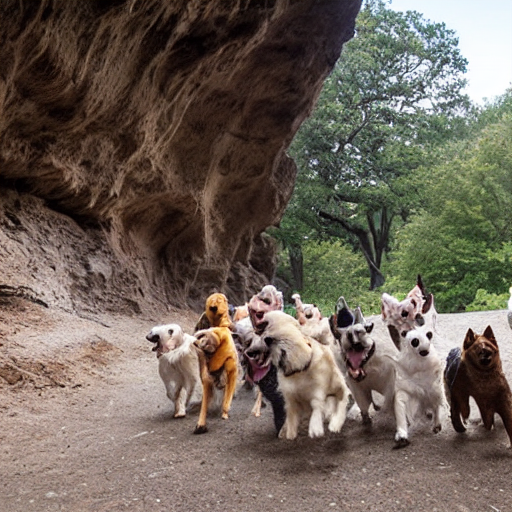

In [37]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [33]:
# torch.save({'model': model.state_dict()}, "custom_model.pth")

In [54]:
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
clip_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet_model = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)
kl_model = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.mlp.fc2.weight', 'vision_model.encoder.layers.19.mlp.fc2.bias', 'vision_model.encoder.layers.6.self_attn.out_proj.bias', 'vision_model.encoder.layers.16.self_attn.v_proj.weight', 'vision_model.encoder.layers.2.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.14.self_attn.q_proj.bias', 'vision_model.encoder.layers.7.layer_norm2.bias', 'vision_model.encoder.layers.17.self_attn.k_proj.weight', 'vision_model.encoder.layers.12.layer_norm1.bias', 'vision_model.encoder.layers.17.mlp.fc1.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.bias', 'vision_model.encoder.layers.4.layer_norm1.bias', 'vision_model.encoder.layers.15.self_attn.q_proj.bias', 'vision_model.pre_layrnorm.weight', 'vision_model.encoder.layers.14.mlp.fc1.wei

In [59]:
clip_tokenizer.save_pretrained('./model/tokenizer/')

('./model/tokenizer/tokenizer_config.json',
 './model/tokenizer/special_tokens_map.json',
 './model/tokenizer/vocab.json',
 './model/tokenizer/merges.txt',
 './model/tokenizer/added_tokens.json')

In [56]:
kl_model.save_pretrained('./model/vae')
unet_model.save_pretrained('./model/unet')
clip_model.save_pretrained('./model/cliptext')

In [57]:
clip_model = CLIPTextModel.from_pretrained('./model/cliptext')